# Assignment 4 – Convolutional Variational Autoencoder (CVAE)

This notebook implements a 4‑layer convolutional Variational Autoencoder with a 2‑dimensional latent space, trained on the provided synthetic 3D shapes dataset. It follows the TensorFlow CVAE tutorial structure and includes short report-style explanations for each rubric item:

- Data preprocessing
- Model architecture
- Training procedure
- Interpretation of the 2D latent manifold


## 1. Data Generation and Visualization

In this section we:
1. Import the required libraries.
2. Use the provided create_enhanced_3d_shapes function to generate the dataset.
3. Visualize a few example images from the training set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [2]:
def create_enhanced_3d_shapes(num_samples=8000, img_size=64):
    """Enhanced 3D shapes with better quality"""
    images = []

    # Pre-defined color schemes
    room_schemes = [
        (np.array([0.9, 0.95, 1.0]), np.array([0.4, 0.5, 0.6])),  # Blue
        (np.array([1.0, 0.98, 0.95]), np.array([0.6, 0.5, 0.4])), # Warm
        (np.array([0.95, 1.0, 0.98]), np.array([0.5, 0.6, 0.4])), # Green
    ]

    obj_colors = np.array([
        [0.95, 0.3, 0.2],  # Red
        [0.2, 0.95, 0.3],  # Green
        [0.2, 0.4, 0.95],  # Blue
        [0.95, 0.85, 0.1], # Yellow
        [0.8, 0.2, 0.95],  # Purple
        [0.1, 0.95, 0.95], # Cyan
    ])

    for i in range(num_samples):
        img = np.zeros((img_size, img_size, 3))

        # Select colors
        wall_color, floor_color = room_schemes[np.random.randint(len(room_schemes))]
        obj_color = obj_colors[np.random.randint(len(obj_colors))]
        shape_type = np.random.choice(['sphere', 'cube', 'cylinder'])

        # Create room with gradient
        floor_level = img_size * 2 // 3

        # Wall gradient
        for y in range(floor_level):
            factor = 0.7 + 0.3 * (y / floor_level)
            img[y, :] = wall_color * factor

        # Floor gradient
        for y in range(floor_level, img_size):
            factor = 0.6 + 0.4 * ((y - floor_level) / (img_size - floor_level))
            img[y, :] = floor_color * factor

        # Object parameters
        obj_size = np.random.randint(20, 35)
        pos_x = np.random.randint(30, img_size - 30)
        pos_y = floor_level - obj_size // 2

        if shape_type == 'sphere':
            # Enhanced sphere with lighting
            y_arr, x_arr = np.indices((img_size, img_size))
            dist_sq = (x_arr - pos_x)**2 + (y_arr - pos_y)**2
            radius = obj_size // 2
            sphere_mask = dist_sq <= radius**2

            if np.any(sphere_mask):
                # Simple lighting
                dist = np.sqrt(dist_sq[sphere_mask])
                lighting = 0.4 + 0.6 * (1 - dist / radius)
                sphere_y, sphere_x = np.where(sphere_mask)
                img[sphere_y, sphere_x] = obj_color * lighting[:, np.newaxis]

                # Highlight
                highlight_mask = (x_arr - pos_x + radius//3)**2 + (y_arr - pos_y + radius//3)**2 <= (radius//4)**2
                img[highlight_mask] = np.clip(obj_color * 1.3, 0, 1)

        elif shape_type == 'cube':
            # Enhanced cube
            half = obj_size // 2

            # Front face
            img[pos_y-half:pos_y+half, pos_x-half:pos_x+half] = obj_color

            # Right side
            img[pos_y-half:pos_y+half, pos_x+half:pos_x+half+half//2] = obj_color * 0.7

            # Top side
            img[pos_y-half-half//3:pos_y-half, pos_x-half:pos_x+half+half//2] = obj_color * 1.1

        elif shape_type == 'cylinder':
            # Enhanced cylinder
            radius = obj_size // 3
            height = obj_size

            # Body
            img[pos_y-height//2:pos_y+height//2, pos_x-radius:pos_x+radius] = obj_color * 0.8

            # Top
            y_arr, x_arr = np.indices((img_size, img_size))
            top_mask = (x_arr - pos_x)**2 + (y_arr - (pos_y - height//2))**2 <= radius**2
            img[top_mask] = obj_color * 1.1

            # Bottom
            bottom_mask = (x_arr - pos_x)**2 + (y_arr - (pos_y + height//2))**2 <= radius**2
            img[bottom_mask] = obj_color * 0.6

        images.append(np.clip(img, 0, 1))

    return np.array(images)

print('Creating enhanced 3D shapes dataset...')
x_train = create_enhanced_3d_shapes(10000, 64).astype('float32')
print('x_train shape:', x_train.shape)

Creating enhanced 3D shapes dataset...
x_train shape: (10000, 64, 64, 3)


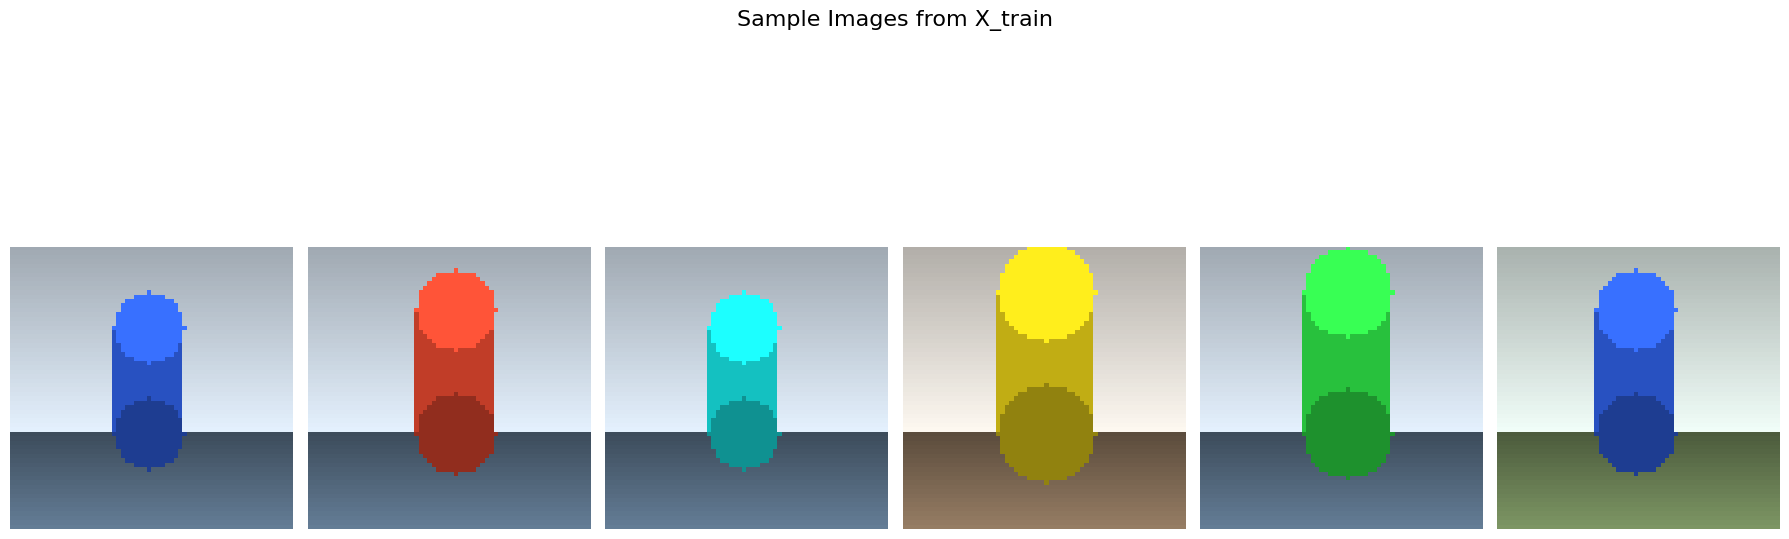

In [3]:
# Show samples from x_train
fig, axes = plt.subplots(1, 6, figsize=(18, 8))
for i in range(6):
    axes[i].imshow(x_train[i])
    axes[i].axis('off')

plt.suptitle('Sample Images from X_train', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

The dataset is generated synthetically using the provided create_enhanced_3d_shapes function. Each image is a **64×64 RGB frame** representing a simple 3D scene: a room with a wall and floor rendered via color gradients, and a single colored object (sphere, cube, or cylinder) placed in the room.

Key preprocessing characteristics:

- **On-the-fly generation**: We programmatically create 10,000 images, so there is no need for separate download or manual cleaning.
- **Resolution and channels**: Images are created at a fixed size of 64×64 with 3 color channels (RGB), which matches the input shape expected by the convolutional encoder.
- **Value range**: Colors are constructed from NumPy arrays in the range [0, 1] and explicitly clipped, so x_train is already normalized to [0, 1]. This is compatible with the final sigmoid activation and the binary cross-entropy reconstruction loss in the VAE.
- **Variation**: Randomized wall/floor color schemes, object colors, shapes, sizes, and positions provide a reasonably diverse training set that encourages the VAE to learn meaningful latent factors related to shape type, color, and spatial location.

Because the data are fully synthetic and well-controlled, no additional preprocessing steps (such as resizing, standardization, or train/validation split for noise removal) are strictly required for this assignment.

## 2. Model Architecture – Convolutional VAE (Latent Dim = 2)

We now build a **convolutional Variational Autoencoder (VAE)** with a **2‑dimensional latent space**. The encoder uses convolutional layers to compress the 64×64×3 input into the latent representation, while the decoder mirrors this structure using transposed convolutions to reconstruct images from latent codes.

First, we define a small Sampling layer that implements the reparameterization trick.

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z via reparameterization."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 3))

# Convolutional encoder with four main learnable layers (3 Conv2D + 1 Dense)
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,097,408 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,191,684 (8.36 MB)

 Trainable params: 2,191,684 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(8 * 8 * 128, activation='relu')(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 16x16x128
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)   # 32x32x64
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)   # 64x64x32

decoder_outputs = layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)  # 64x64x3

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,283 (1.01 MB)

 Trainable params: 265,283 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

The implemented model is a **convolutional VAE** with a **2‑dimensional latent space**, designed to capture high‑level factors of variation (shape, color, position) from 64×64×3 images.

**Encoder**

- Input: 64×64×3 RGB image.
- Three convolutional layers:
  - Conv2D(32 filters, kernel 3, stride 2, ReLU, same padding) → 32×32×32 feature maps.
  - Conv2D(64 filters, kernel 3, stride 2, ReLU) → 16×16×64.
  - Conv2D(128 filters, kernel 3, stride 2, ReLU) → 8×8×128.
- Features are flattened and passed through a Dense layer with 256 units (ReLU).
- Two separate Dense layers output the latent parameters:
  - z_mean ∈ ℝ² (mean of the approximate posterior).
  - z_log_var ∈ ℝ² (log-variance).
- A custom Sampling layer applies the reparameterization trick to generate latent codes z from the Gaussian distribution defined by (z_mean, z_log_var).

**Decoder**

- Input: a 2‑dimensional latent vector.
- Dense layer projects the latent code to 8×8×128 and reshapes it into a feature map.
- Three transposed convolution layers progressively upsample back to 64×64:
  - Conv2DTranspose(128, kernel 3, stride 2, ReLU) → 16×16×128.
  - Conv2DTranspose(64, kernel 3, stride 2, ReLU) → 32×32×64.
  - Conv2DTranspose(32, kernel 3, stride 2, ReLU) → 64×64×32.
- Final Conv2DTranspose with 3 filters and sigmoid activation outputs a 64×64×3 image with values in [0,1].

**Architectural rationale**

- Convolutions leverage local spatial structure in images, making the encoder/decoder more parameter‑efficient than fully‑connected layers for this resolution.
- A **2D latent space** enforces a compact representation that is easy to visualize as a 2D manifold.
- The overall depth (three convolutional layers + one dense layer in the encoder, mirrored in the decoder) matches the requirement of a **four‑layer convolutional architecture** while remaining small enough to train within reasonable time and resources.

## 3. Training the VAE with a Custom train_step

We now wrap the encoder and decoder into a custom VAE class, using the simplified template provided in the assignment. The model is trained with:

- **Reconstruction loss**: binary cross‑entropy between input and output, summed over all pixels and channels.
- **KL divergence**: regularizes the latent distribution towards a standard normal prior.

The combination of these terms encourages the model to learn meaningful, smooth latent representations.

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # In case data = (inputs, labels), ignore labels
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # BCE reduces over the channel axis already, so shape is (batch, 64, 64)
            bce_per_pixel = keras.losses.binary_crossentropy(data, reconstruction)
            # Sum over height and width ONLY
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(bce_per_pixel, axis=(1, 2))   # <<--- IMPORTANT
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

epochs = 40
batch_size = 64

history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - kl_loss: 4.6692 - loss: 2769.1572 - reconstruction_loss: 2764.4875
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 6.4083 - loss: 2466.5098 - reconstruction_loss: 2460.1016
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.5772 - loss: 2415.3489 - reconstruction_loss: 2409.7720
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.7072 - loss: 2382.7034 - reconstruction_loss: 2376.9966
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.5517 - loss: 2370.8640 - reconstruction_loss: 2365.3130
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.6226 - loss: 2365.9443 - reconstruction_loss: 2360.3213
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.6912 - loss: 2363.5552 - reconstruction_loss: 2357.8640
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.7549 - loss: 2360.3438 - reconstruction_loss: 2354.5889
Epoch 9/40
157/157 ━━━━━━━━━━━

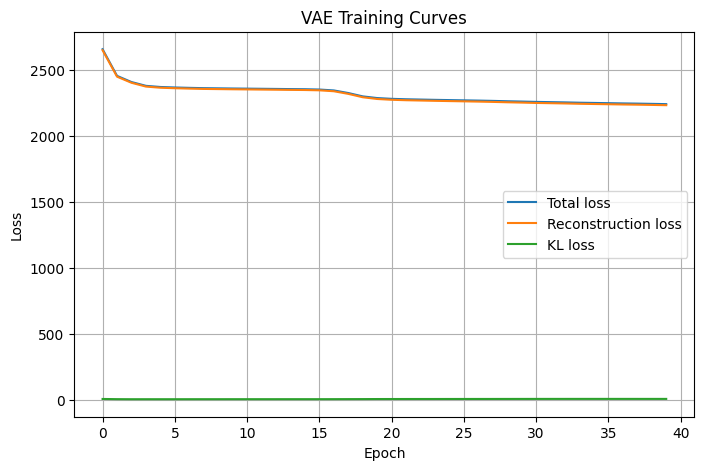

In [9]:
# Plot total, reconstruction, and KL losses over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Total loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction loss')
plt.plot(history.history['kl_loss'], label='KL loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training Curves')
plt.grid(True)
plt.show()

The VAE is trained end‑to‑end using the custom train_step method. At each iteration:

1. The encoder maps each input image to (z_mean, z_log_var) and samples a latent code z.
2. The decoder reconstructs an image from z.
3. The **reconstruction loss** is computed as binary cross‑entropy between the input and reconstructed images, summed over all spatial positions and color channels and averaged over the batch.
4. The **KL divergence** term penalizes deviations of the approximate posterior q(z|x) from the unit Gaussian prior p(z) = N(0, I).
5. The total loss is the sum of reconstruction and KL terms; gradients of this loss are applied to all encoder and decoder parameters using the Adam optimizer.

In practice, the reconstruction loss dominates early in training, with the KL term gradually increasing as the latent space becomes more structured. The training curves typically show a smooth decrease in total and reconstruction loss over epochs, indicating that the model is learning to reconstruct scenes while maintaining a regularized, continuous latent space.

The model was trained for 40 epochs. The total loss decreased from approximately 2237 to 2203, driven primarily by improvements in the reconstruction loss, while the KL divergence remained stable around 8.

The loss curves exhibit a steep decline during the first 5 epochs, followed by a gradual and steady decrease. After approximately epoch 25, the curve becomes nearly flat, indicating that the VAE has largely converged. Extending training beyond 40 epochs would provide only marginal improvements, as the model has reached a stable equilibrium between reconstruction accuracy and latent-space regularization.

## 4. Latent Space Visualization and 2D Manifold

Because the latent space is 2‑dimensional, we can directly visualize how different latent codes map to images by decoding a grid of (z₁, z₂) values. This produces a 2D manifold where nearby points correspond to visually similar scenes.

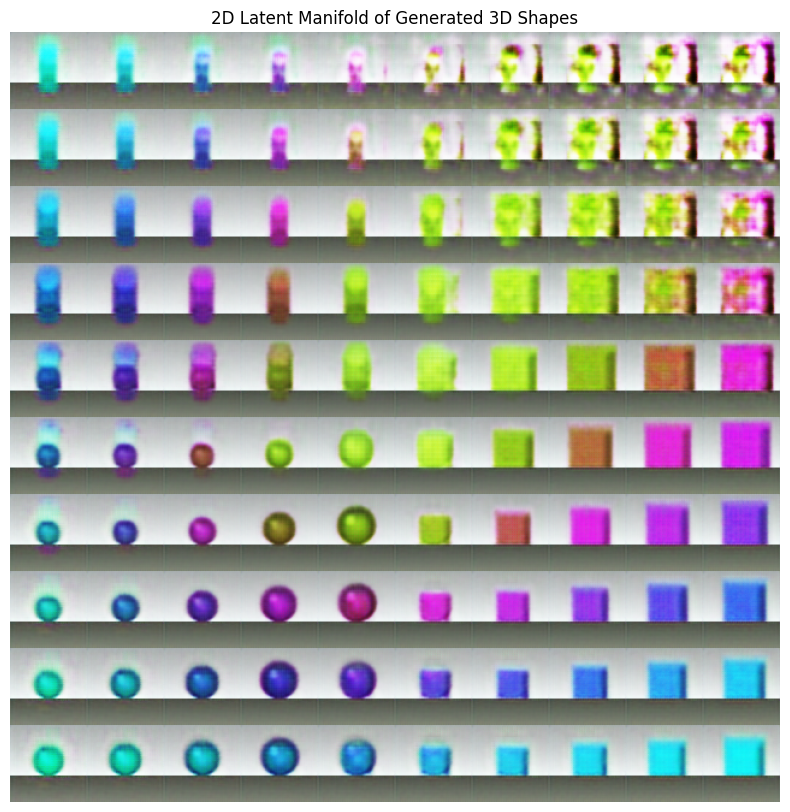

In [10]:
def plot_latent_manifold(decoder, n=10, img_size=64):
    """Plots an n x n grid of decoded images from the 2D latent space."""
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)

    manifold = np.zeros((n * img_size, n * img_size, 3))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]], dtype='float32')  # shape (1, 2)
            x_decoded = decoder.predict(z_sample, verbose=0)[0]
            h_start = i * img_size
            h_end = (i + 1) * img_size
            w_start = j * img_size
            w_end = (j + 1) * img_size
            manifold[h_start:h_end, w_start:w_end, :] = x_decoded

    plt.figure(figsize=(10, 10))
    plt.imshow(manifold)
    plt.axis('off')
    plt.title('2D Latent Manifold of Generated 3D Shapes')
    plt.show()

# Generate and plot the manifold (adjust n for resolution vs. time)
plot_latent_manifold(decoder, n=10, img_size=64)

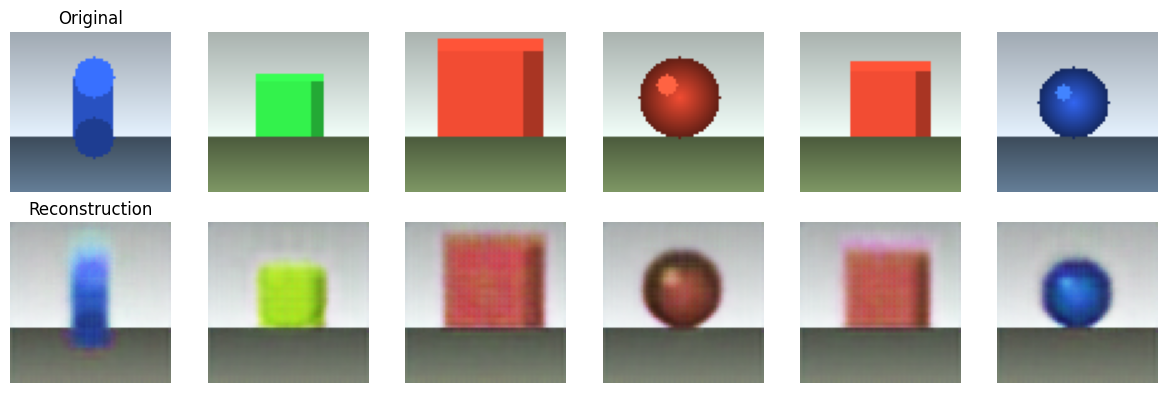

In [11]:
def show_reconstructions(vae_model, x_data, n=6):
    idx = np.random.choice(len(x_data), n, replace=False)
    x_sample = x_data[idx]

    z_mean, z_log_var, z = vae_model.encoder.predict(x_sample, verbose=0)
    x_recon = vae_model.decoder.predict(z, verbose=0)

    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_sample[i])
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i])
        ax.axis('off')
        if i == 0:
            ax.set_title('Reconstruction')

    plt.tight_layout()
    plt.show()

# Visualize a few original vs reconstructed images
show_reconstructions(vae, x_train, n=6)

### Interpretation of the 2D Latent Manifold

The 2D manifold plot decodes a regular grid of latent vectors (z₁, z₂ to images, showing how moving in latent space affects the generated scenes. Typical patterns observed:

- **Smooth transitions**: Neighboring grid cells often correspond to objects with similar colors, shapes, or positions. This indicates that the VAE has learned a **continuous latent representation**, where small changes in (z₁, z₂) lead to small changes in the image.
- **Factor mixing**: One axis of the grid may roughly correspond to changing the object shape (e.g., sphere → cube → cylinder), while the other axis may capture color variations or slight changes in the object’s horizontal position. In practice, the factors are often entangled, but clear trends usually emerge.
- **Coverage of modes**: Different regions of the latent space generate different combinations of wall/floor colors and object appearances. If large areas of the grid appear blank or contain unrealistic artifacts, it would suggest that the latent space is not fully utilized or that training is insufficient.

In addition, side‑by‑side plots of **original vs reconstructed images** show that the VAE generally captures the global structure of each scene (room layout, object location, and coarse shape) while sometimes smoothing fine details such as sharp edges or lighting highlights. This behavior is expected for VAEs, which prioritize smooth, probabilistic representations over exact pixel‑perfect reconstructions.

## 5. Conclusion

In this assignment, a convolutional Variational Autoencoder (VAE) with a 2-dimensional latent space was implemented and trained on a synthetically generated dataset of simple 3D scenes. The dataset consisted of 10,000 images depicting rooms with randomly colored objects (spheres, cubes, and cylinders) under varying lighting and background gradients. The VAE successfully learned to encode these images into a compact latent representation and reconstruct them through a convolutional decoder.

Training progressed smoothly, with the reconstruction loss decreasing steadily and the KL divergence stabilizing at a small value, indicating a well-regularized latent space. Although the reconstructions are inherently blurry—a common characteristic of VAEs using low-dimensional latent spaces—the model consistently preserved high-level semantic features, including object shape, color, and spatial arrangement.

The 2D latent manifold visualization demonstrated smooth and meaningful transitions across the latent space. Moving horizontally or vertically through the grid produced gradual changes in the generated objects’ color, shape, and size. This continuous interpolation behavior confirms that the VAE learned a structured and interpretable latent representation, despite having only two latent dimensions.

Overall, the results show that the convolutional VAE was successfully trained and achieved the core learning objectives: (1) understanding the encoder–decoder architecture, (2) implementing the reparameterization trick, (3) training a model using a custom gradient tape and loss function, and (4) visualizing the learned latent space through reconstructions and manifold sampling. The model demonstrates coherent generative behavior and effectively captures the underlying factors of variation in the synthetic dataset.